<a href="https://colab.research.google.com/github/valak616/AIGLAUCOMA/blob/main/Glau1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [111]:
glau_df = pd.read_csv('/content/drive/MyDrive/GlauPho/ORIGA/glauc.csv')

In [112]:
glau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB


In [113]:
glau_df.head(10)

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
5,006.jpg,0.6451,OD,B,0
6,007.jpg,0.5255,OS,A,0
7,008.jpg,0.4974,OD,B,0
8,009.jpg,0.5273,OD,B,0
9,010.jpg,0.4451,OD,B,0


In [114]:
glau_df['Glaucoma'].value_counts()

0    482
1    168
Name: Glaucoma, dtype: int64

In [115]:
glau_df

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [116]:
glau_df['Glaucoma'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [143]:
# Usaremos plotly para hacer un diagrama de barras interactivo
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = glau_df['Glaucoma'].value_counts().index, y = glau_df['Glaucoma'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [118]:
# Creamos el generador de imágenes
from keras_preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.20)

In [119]:
glau_df_train = glau_df.drop(columns = ['Eye'])
glau_df_train.shape

(650, 4)

In [120]:
glau_df_train['Glaucoma'] = glau_df_train['Glaucoma'].apply(lambda x: str(x))

In [121]:
glau_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Set       650 non-null    object 
 3   Glaucoma  650 non-null    object 
dtypes: float64(1), object(3)
memory usage: 20.4+ KB


In [122]:
# Dividir los datos en entrenamiento y testing

from sklearn.model_selection import train_test_split

train, test = train_test_split(glau_df_train, test_size = 0.20)

In [123]:
# Creamos el generador de imágenes
from keras_preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.20)


In [124]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= '/content/drive/MyDrive/GlauPho/ORIGA/Images',
x_col='Filename',
y_col='Glaucoma',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= '/content/drive/MyDrive/GlauPho/ORIGA/Images',
x_col='Filename',
y_col='Glaucoma',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para imágenes de prueba
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= '/content/drive/MyDrive/GlauPho/ORIGA/Images',
x_col='Filename',
y_col='Glaucoma',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 416 validated image filenames belonging to 2 classes.
Found 104 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.


In [125]:
# Obtenemos el modelo base de ResNet50 
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [126]:
# Congelamos los pesos del modelo

for layer in basemodel.layers:
  layers.trainable = False

In [127]:
 # Agregamos una cabecera de clasificación al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [128]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [129]:
# Compilamos el modelo

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [130]:
# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [131]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 20, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/20
26/26 [==============================] - 411s 16s/step - loss: 0.8630 - accuracy: 0.6923 - val_loss: 64.1679 - val_accuracy: 0.7604

Epoch 00001: val_loss improved from inf to 64.16794, saving model to classifier-resnet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/20
26/26 [==============================] - 402s 15s/step - loss: 0.7262 - accuracy: 0.7188 - val_loss: 7798.8301 - val_accuracy: 0.7812

Epoch 00002: val_loss did not improve from 64.16794
Epoch 3/20
26/26 [==============================] - 400s 15s/step - loss: 0.6082 - accuracy: 0.7452 - val_loss: 185.7565 - val_accuracy: 0.7812

Epoch 00003: val_loss did not improve from 64.16794
Epoch 4/20
26/26 [==============================] - 398s 15s/step - loss: 0.6066 - accuracy: 0.7428 - val_loss: 117.8607 - val_accuracy: 0.7812

Epoch 00004: val_loss did not improve from 64.16794
Epoch 5/20
26/26 [==============================] - 400s 15s/step - loss: 0.5768 - accuracy: 0.7500 - val_loss: 0.9004 - val_accuracy: 0.7812

Epoch 00005: val_loss improved from 64.16794 to 0.90037, saving model to classifier-resnet-weights.hdf5
Epoch 6/20
26/26 [==============================] - 402s 15s/step - loss: 0.5666 - accuracy: 0.7500 - val_loss: 8.6760 - val_accuracy: 0.7812

Epoch 00006: val_l

In [132]:

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



# EVALUANDO EL RENDIMIENTO

In [133]:
with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargar el modelo  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier-resnet-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [134]:
# Hacemos la predicción

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

8/8 [==============================] - 35s 4s/step


In [135]:
test_predict.shape

(128, 2)

In [136]:
test_predict

array([[0.7442217 , 0.25577834],
       [0.70609796, 0.29390204],
       [0.76213527, 0.2378647 ],
       [0.91976994, 0.08023011],
       [0.7204655 , 0.27953455],
       [0.77320063, 0.22679944],
       [0.7569971 , 0.24300294],
       [0.7784293 , 0.22157066],
       [0.7989458 , 0.20105417],
       [0.70187503, 0.29812503],
       [0.79127187, 0.2087281 ],
       [0.73544604, 0.2645539 ],
       [0.8812023 , 0.11879767],
       [0.780122  , 0.21987806],
       [0.75067955, 0.24932048],
       [0.74965394, 0.25034606],
       [0.838137  , 0.16186297],
       [0.80102074, 0.19897926],
       [0.7470208 , 0.25297922],
       [0.71877646, 0.28122354],
       [0.6879395 , 0.3120605 ],
       [0.75024754, 0.24975248],
       [0.7453509 , 0.2546491 ],
       [0.7605798 , 0.2394202 ],
       [0.7250839 , 0.2749161 ],
       [0.7274908 , 0.27250925],
       [0.72443056, 0.27556944],
       [0.76145744, 0.23854257],
       [0.8115982 , 0.18840185],
       [0.8065082 , 0.19349182],
       [0.

In [137]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)


In [138]:
predict

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], dtype='<U1')

In [139]:
original = np.asarray(test['Glaucoma'])[:len(predict)]
len(original)

128

In [140]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.6875

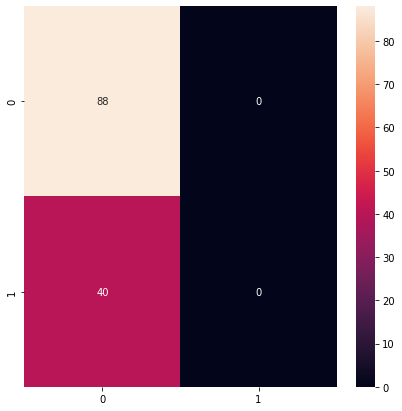

In [141]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [142]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        88
           1       0.00      0.00      0.00        40

   micro avg       0.69      0.69      0.69       128
   macro avg       0.34      0.50      0.41       128
weighted avg       0.47      0.69      0.56       128



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

